In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib.dates as mdates


In [18]:
PATH_TO_LOAD = "../Processed_data_new/01_MF4_Extracted"

df = pd.read_csv(os.path.join(PATH_TO_LOAD, "SEB883_extracted_mf4.csv"), parse_dates=['datetime'])

In [19]:
df = df[["CHA_ESP_drive_mode", "session", "datetime"]]
df

,CHA_ESP_drive_mode,session,datetime
0,0.0,1149.0,2022-09-07 20:36:39
1,0.0,1149.0,2022-09-07 20:36:40
2,0.0,1149.0,2022-09-07 20:36:40
3,0.0,1149.0,2022-09-07 20:36:42
4,0.0,1149.0,2022-09-07 20:36:43
...,...,...,...
3985328,NaN,2371.0,2023-06-24 20:31:26
3985329,NaN,2371.0,2023-06-24 20:31:27
3985330,NaN,2371.0,2023-06-24 20:31:27
3985331,NaN,2371.0,2023-06-24 20:31:29


In [22]:
df_changes_all = df.copy()
df_changes = df.copy()

for i, sess in enumerate(df.session.unique()):

        df_sess = df[df.session == sess]
        
        change_indices = df_sess.index[df_sess["CHA_ESP_drive_mode"].diff() != 0]
        if len(change_indices) <= 1:  # Skip if there's no interaction
            continue
        else:
            change_indices = change_indices[1:]

            df_changes_all.loc[change_indices, "label"] = df_sess.loc[change_indices, "CHA_ESP_drive_mode"] 
            
            # Check time difference between changes
            time_diff = df_sess.loc[change_indices, "datetime"].diff()
            time_threshold = pd.Timedelta(minutes=1)  # Adjust the time threshold as needed
            
            time_diff_shift = time_diff.fillna(pd.Timedelta(0)).shift(-1).fillna(pd.Timedelta(minutes=5))

            # Keep only the last change if time difference is less than the threshold
            #last_change_index = change_indices[np.logical_and(time_diff > time_threshold, time_diff_shift > time_threshold)] #[-1:]
            last_change_index = change_indices[time_diff_shift > time_threshold] #[-1:]
          
            df_changes.loc[last_change_index, "label"] = df_sess.loc[last_change_index, "CHA_ESP_drive_mode"] 


In [23]:
driveMode_map = {
    "0.0": "Normal",
    "0": "Normal",
    "1.0": "Sport",
    "1": "Sport",
    "2.0": "SuperSport",
    "2": "SuperSport",
    "3.0": "Range",
    "3": "Range",
    "4.0": "Gravel-Offroad"
}

def drive_mode_label_formatter(x, pos):
    return driveMode_map[str(int(x))] if str(int(x)) in driveMode_map else str(x)



duration:  0 days 03:24:05
CHA_ESP_drive_mode
0.0    6404
3.0    4509
2.0     857
1.0     165
Name: count, dtype: int64


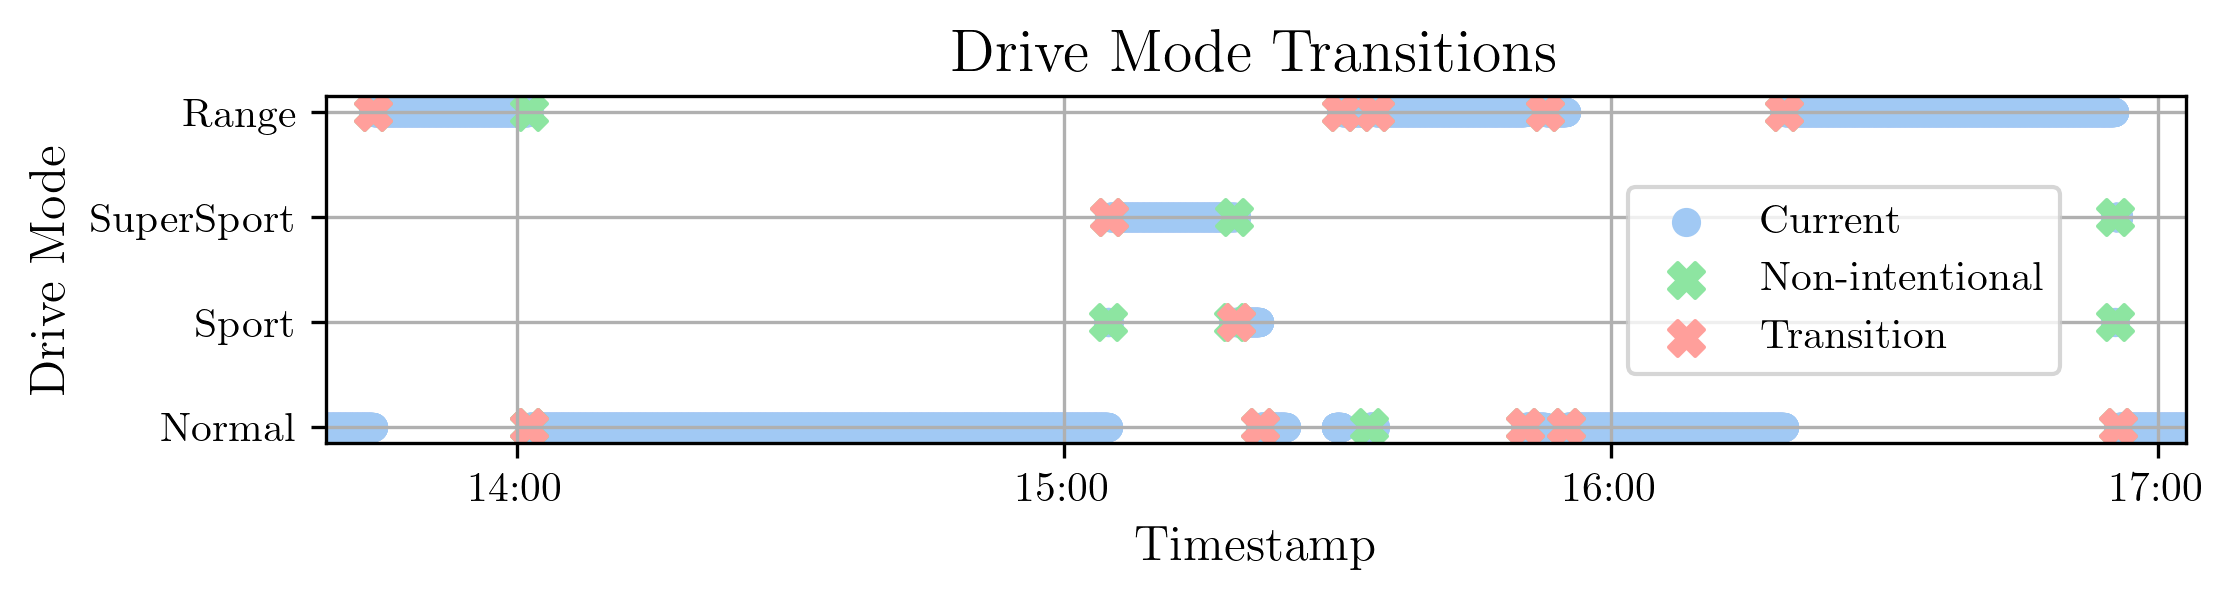

SystemExit: 

In [28]:
from matplotlib.ticker import FuncFormatter

count = 0

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",  # You can change this to match your preference
#     "font.serif": ["Times New Roman"],  # Use the LaTeX font you want
# })

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,  # Adjust the font size for all elements
    "axes.labelsize": 12,  # Font size of axis labels
    "xtick.labelsize": 10,  # Font size of x-axis tick labels
    "ytick.labelsize": 10,  # Font size of y-axis tick labels
    "legend.fontsize": 10,  # Font size of legend
    "figure.titlesize": 14,  # Font size of figure title
})

for i, sess in enumerate(df.session.unique()):
    
    df_sess_c = df_changes[df_changes.session == sess]
    df_sess_c_a = df_changes_all[df_changes_all.session == sess]
    df_sess = df[df.session == sess]


    
    if len(df_sess_c.label.unique()) > 3 and count ==10:

        plt.figure(figsize=(8, 1.5), dpi=300)
        colors = sns.color_palette("pastel")
        
        print("duration: ", df_sess.datetime.iloc[-1] - df_sess.datetime.iloc[0])
        if len(df_sess.CHA_ESP_drive_mode.value_counts()) < 1:
            print("no interactioin")
            sys.exit()
        print(df_sess.CHA_ESP_drive_mode.value_counts())

        plt.scatter(df_sess.datetime, df_sess.CHA_ESP_drive_mode, color=colors[0], label="Current")
        plt.scatter(df_sess_c_a.datetime, df_sess_c_a.label, marker='X', s=70, color=colors[2], label="Non-intentional")
        plt.scatter(df_sess_c.datetime, df_sess_c.label, marker='X', s=70, color=colors[3], label="Transition")
        

        plt.gca().yaxis.set_major_formatter(FuncFormatter(drive_mode_label_formatter))

        # Customize x-axis to display only the hour
        hours = mdates.HourLocator(interval=1)
        h_fmt = mdates.DateFormatter("%H:%M")
        plt.gca().xaxis.set_major_locator(hours)
        plt.gca().xaxis.set_major_formatter(h_fmt)
        
        #plt.xticks(rotation=45)
        plt.xlim(df_sess.datetime.min(), df_sess.datetime.max())
        plt.grid(True) 
        plt.xlabel(f'Timestamp')
        plt.ylabel('Drive Mode')
        plt.title(f'Drive Mode Transitions')
        plt.legend(loc=(0.7, 0.2))
        plt.savefig("/Users/wannerje/Dropbox/Porsche/eth_report/Img/plot.pdf", format="pdf", bbox_inches="tight")
        plt.show()
        sys.exit()
    if len(df_sess_c.label.unique()) > 3:
        count+=1

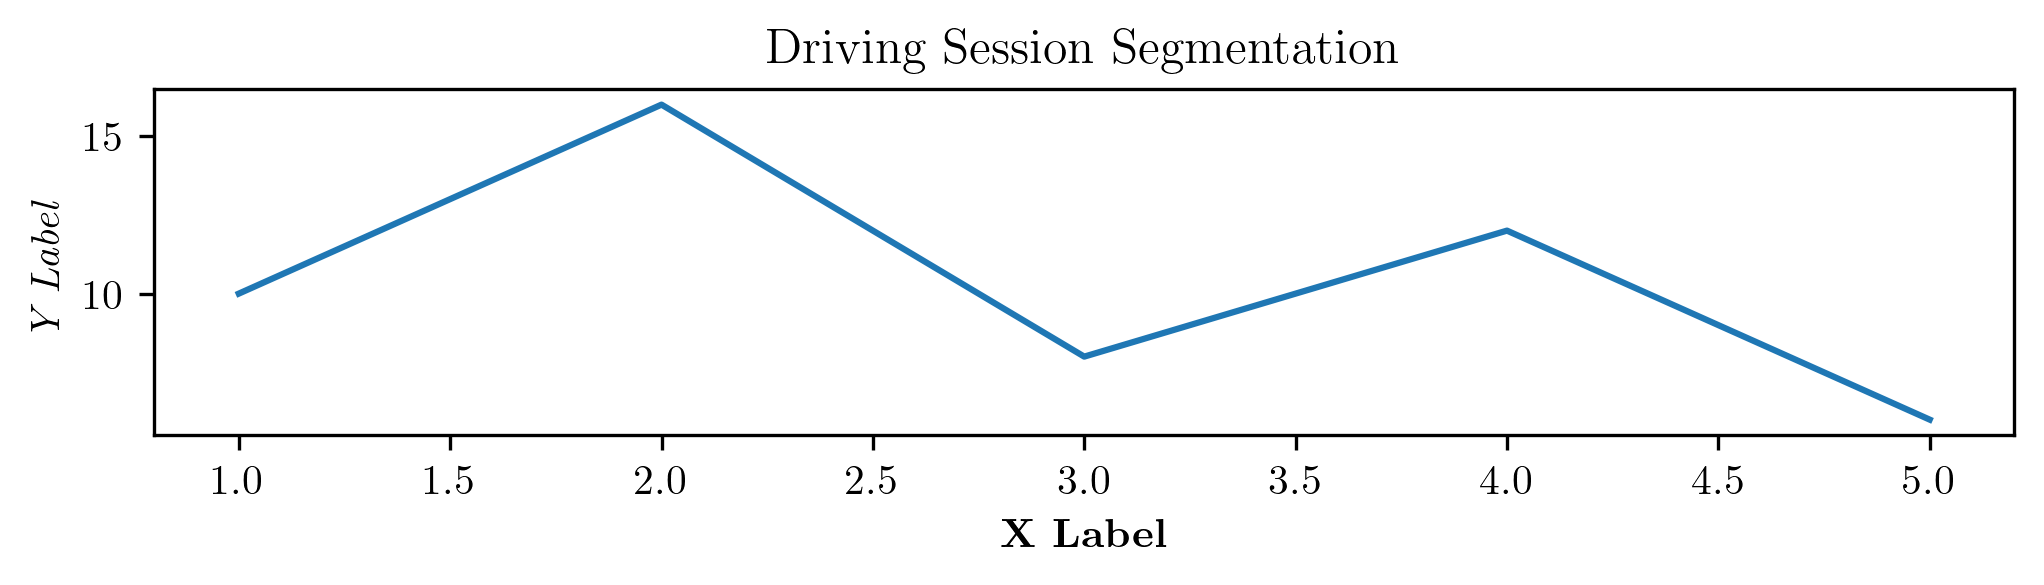

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # You can change this to match your preference
    "font.serif": ["Times New Roman"],  # Use the LaTeX font you want
})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],  # Use the Computer Modern font
# })

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

plt.figure(figsize=(8, 1.5), dpi=300)

x = [1, 2, 3, 4, 5]
y = [10, 16, 8, 12, 6]

plt.plot(x, y)
plt.xlabel(r'\textbf{X Label}')
plt.ylabel(r'\textit{Y Label}')
plt.title("Driving Session Segmentation")
plt.show()

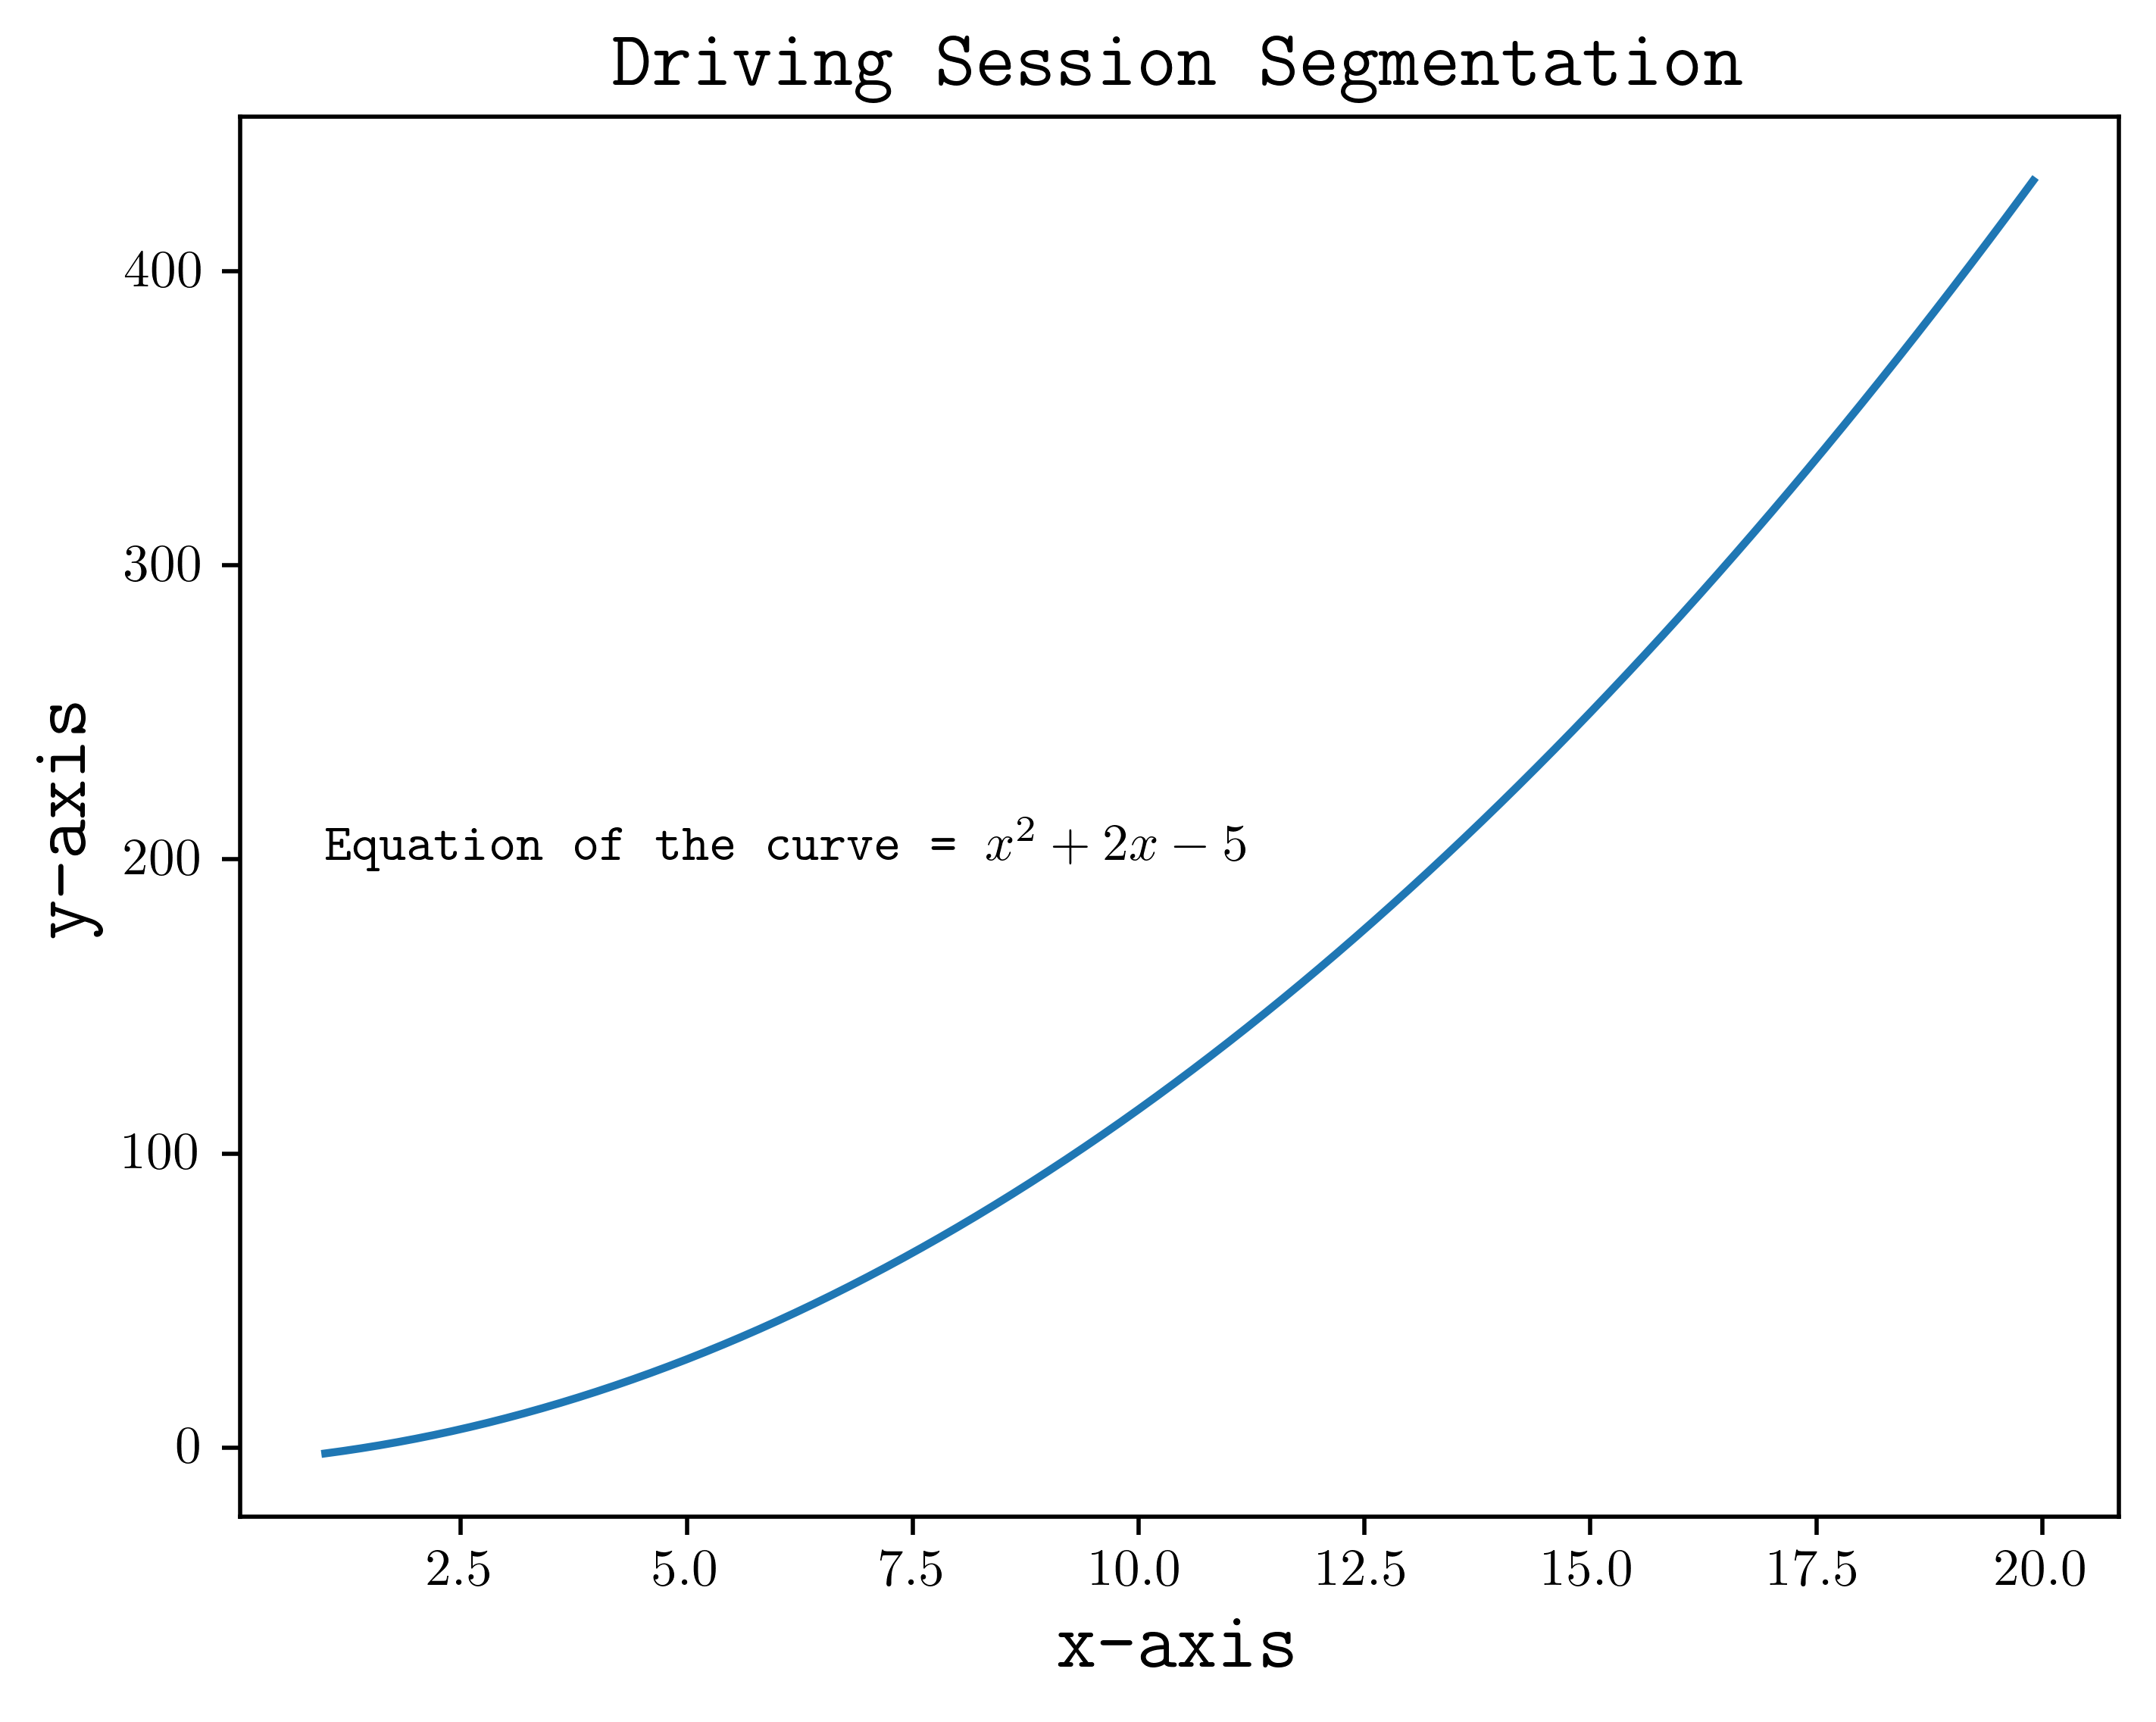

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Increasing the resolution of the plot
plt.figure(dpi=500)

# Activating text rendering by LaTex
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern Typewriter'
})

x = np.arange(1,20,0.1)
y= x**2+ 2*x -5 

# Adding text at specified coordinates
plt.text(x=1.0,y=200,s='Equation of the curve = $x^2+ 2x -5$')

plt.xlabel('x-axis',fontsize=15)
plt.ylabel('y-axis',fontsize=15)
plt.title('Driving Session Segmentation',fontsize=15)
plt.plot(x,y)
plt.show()